# Using the NN model to calculate monthly estimate

Below are code to uses ESA Scope project WP2 DOC model to estimate monthly DOC for given input data.
The model is a neural network model using Pytorch package. File `requirements.txt` lists the Python package requirements.

In [1]:
import numpy as np
import xarray as xr
import scope_doc_model as m
import scope_config as config

In [2]:
device = m.get_torch_device()
print(f'Using device: {device}')

Using device: cpu



### Input data

| variable | name | units | link |
|:--|:--|:--|:--|
|OC-CCI v6 | Rrs_nnn | sr⁻¹ | https://dx.doi.org/10.5285/5011d22aae5a4671b0cbc7d05c56c4f0 |
|PP    | pp | mgC m⁻² d⁻¹ | https://rsg.pml.ac.uk/shared_files/gku/SCOPE/PP_v6_9km/ |
|SST   | temp | °C | https://dx.doi.org/10.5285/4a9654136a7148e39b7feb56f8bb02d2 |
|SSS   | salt | PSS-78 | https://doi.org/10.48670/moi-00021 |
|dts   | dts |  km | distance to shore `dts_rot_1279l4_0.1x0.1.grb_v4_unpack.nc` |
|depth | depth | m | `bathy_9km_new_fill_val.nc` (NOT USED in v1.0) |

File `DOC_model_input_2020_06.nc` has an example of input data for one month. It has smaller spatial resolution than the final product.


In [3]:
ds = xr.open_dataset('DOC_model_input_2020_06.nc')
ds

<xarray.Dataset> Size: 30MB
Dimensions:  (lat: 540, lon: 1080)
Coordinates:
  * lat      (lat) float32 2kB -89.83 -89.5 -89.17 -88.83 ... 89.17 89.5 89.83
  * lon      (lon) float32 4kB -179.8 -179.5 -179.2 -178.8 ... 179.2 179.5 179.8
    time     datetime64[ns] 8B ...
    depth    (lat, lon) float32 2MB ...
Data variables:
    salt     (lat, lon) float64 5MB ...
    pp       (lat, lon) float64 5MB ...
    Rrs_412  (lat, lon) float32 2MB ...
    Rrs_443  (lat, lon) float32 2MB ...
    Rrs_490  (lat, lon) float32 2MB ...
    Rrs_510  (lat, lon) float32 2MB ...
    Rrs_560  (lat, lon) float32 2MB ...
    Rrs_665  (lat, lon) float32 2MB ...
    temp     (lat, lon) float32 2MB ...
    dts      (lat, lon) float32 2MB ...
Attributes:
    title:    Demo file for the SCOPE project

### Model

The model definitions are stored in two files.

| file | what |
|:--|:--|
|`nn_model_data_esa-scope_v1.4.pkl`| training data, variables names, and scaler |
|`nn_model_esa-scope_v1.4.keras`| Tensorflow model |

Pytorch version 2.5.1 was used for training and is needed to use the model.

In [4]:
model_version = 'v1.0'

data, model = m.load_model(model_version, device=device)
model

DOCModule(
  (Rrs_encoder): Sequential(
    (0): Conv1d(1, 8, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=45, out_features=32, bias=True)
    (1): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
  )
)

### Estimation

The function `estimate_DOC` defined below uses xarray Dataset as input. The function `model.predict` is used to calculate model predictions for every valid pixel in the input data and outputs similar Dataset with one variable 'DOC'.

In [5]:
DOC = m.estimate_DOC(ds, model, data)
DOC

<xarray.Dataset> Size: 5MB
Dimensions:  (lat: 540, lon: 1080)
Coordinates:
  * lat      (lat) float32 2kB -89.83 -89.5 -89.17 -88.83 ... 89.17 89.5 89.83
  * lon      (lon) float32 4kB -179.8 -179.5 -179.2 -178.8 ... 179.2 179.5 179.8
    time     datetime64[ns] 8B 2020-06-15
    depth    (lat, lon) float32 2MB nan nan nan ... -4.217e+03 -4.216e+03
Data variables:
    DOC      (lat, lon) float32 2MB nan nan nan nan nan ... nan nan nan nan nan

The output is calculated for all pixels that have the input variables. However, the results are valid for only open water oceans (> 300 km from the shore) and below latitude 70°, North and South.

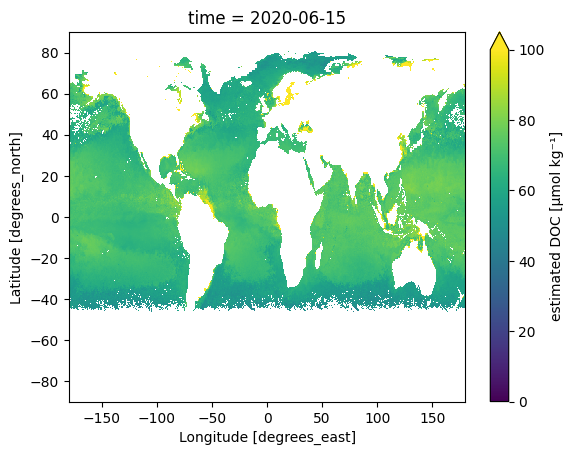

In [6]:
DOC['DOC'].plot(vmin=0, vmax=100);

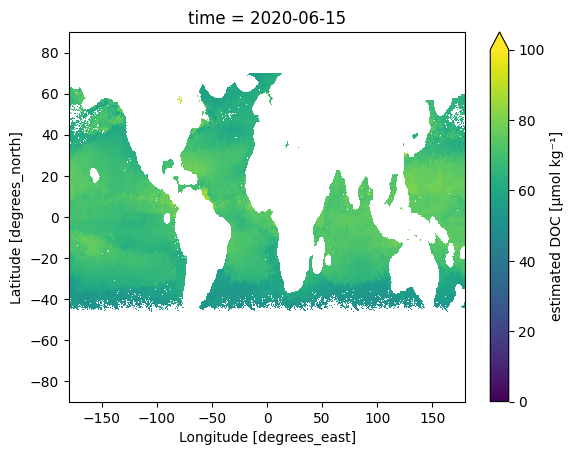

In [7]:
DOC2 = DOC['DOC'].copy()
DOC2 = DOC2.where(ds['dts'] >= config.shorelimit)
DOC2 = DOC2.where(np.abs(ds['lat']) <= config.latlimit)
DOC2.plot(vmax=100, vmin=0);